In [1]:
import os
from glob import glob
import mne
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
plt.rcParams['figure.figsize'] = [8, 6]

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Data loading
all_files_path = glob('/kaggle/input/datanew/newdata2/*.edf')
print(f"Number of EDF files: {len(all_files_path)}")

# Load labels from Excel files
file_path = '/kaggle/input/datanew/newdata2/states(1).xlsx'
df_labels = pd.read_excel(file_path)
labels1 = df_labels['status'].tolist()

file_path2 = '/kaggle/input/datanew/newdata2/States.xlsx'
df_labels2 = pd.read_excel(file_path2)
labels2 = df_labels2['status'].tolist()

labels = labels1 + labels2
labels = [0 if label == 'NORMAL' else 1 for label in labels]

# Separate healthy and patient files
healthy_file_path = [p for p in all_files_path if labels[int(os.path.basename(p).split('.')[0]) - 1] == 0]
patient_file_path = [p for p in all_files_path if labels[int(os.path.basename(p).split('.')[0]) - 1] == 1]
print(f"Healthy files: {len(healthy_file_path)}, Patient files: {len(patient_file_path)}")

# Create test set with 5 patients from each group
test_file_path = healthy_file_path[-5:] + patient_file_path[-5:]
healthy_file_path = healthy_file_path[:-5]
patient_file_path = patient_file_path[:-5]
print(f"Test files: {len(test_file_path)}, Updated Healthy files: {len(healthy_file_path)}, Updated Patient files: {len(patient_file_path)}")

# Create test labels
test_labels = [0] * 5 + [1] * 5  # 5 healthy (0) + 5 patient (1)


Number of EDF files: 61
Healthy files: 32, Patient files: 29
Test files: 10, Updated Healthy files: 27, Updated Patient files: 24


In [2]:
def read_data(file_path):
    datax = mne.io.read_raw_edf(file_path, preload=True)
    datax.set_eeg_reference()
    datax.filter(l_freq=1, h_freq=45)
    epochs = mne.make_fixed_length_epochs(datax, duration=25, overlap=0)
    epochs = epochs.get_data()
    return epochs  # Shape: (trials, channels, length)

# Load and preprocess train/validation data
control_epochs_array = [read_data(subject) for subject in healthy_file_path]
patient_epochs_array = [read_data(subject) for subject in patient_file_path]

# Create labels and group arrays for train/validation
control_epochs_labels = [np.zeros(len(epochs)) for epochs in control_epochs_array]
patient_epochs_labels = [np.ones(len(epochs)) for epochs in patient_epochs_array]
data_array = np.vstack(control_epochs_array + patient_epochs_array)
label_array = np.hstack(control_epochs_labels + patient_epochs_labels)
group_array = np.hstack([np.ones(len(epochs)) * i for i, epochs in enumerate(control_epochs_array + patient_epochs_array)])

# Load and preprocess test data
test_epochs_array = [read_data(subject) for subject in test_file_path]
test_epochs_labels = [np.zeros(len(epochs)) if test_labels[i] == 0 else np.ones(len(epochs)) for i, epochs in enumerate(test_epochs_array)]
test_data_array = np.vstack(test_epochs_array)
test_label_array = np.hstack(test_epochs_labels)

Extracting EDF parameters from /kaggle/input/datanew/newdata2/19.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 465663  =      0.000 ...  1818.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 73 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/13.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/21.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/31.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/36.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/44.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/56.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/24.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/30.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/10.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/26.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/34.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 83 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/27.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 76 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/53.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/41.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/38.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 73 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/12.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 79 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/17.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 76 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/16.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/37.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/29.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/28.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 73 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/18.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/8.edf...
EDF file detected
Setting channel info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/57.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 65 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/1.edf...
EDF file detected
Setting channel info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/55.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 73 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/49.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/25.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/59.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/9.edf...
EDF file detected
Setting channel info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/35.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 71 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/3.edf...
EDF file detected
Setting channel info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 76 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/32.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/23.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/20.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/46.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/15.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/48.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 77 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/14.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/61.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 73 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/51.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 73 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/7.edf...
EDF file detected
Setting channel info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/50.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 76 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/43.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/47.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/40.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 73 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/33.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 77 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/2.edf...
EDF file detected
Setting channel info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/60.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


Extracting EDF parameters from /kaggle/input/datanew/newdata2/42.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 476415  =      0.000 ...  1860.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/5.edf...
EDF file detected
Setting channel info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/4.edf...
EDF file detected
Setting channel info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/45.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 70 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/39.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 72 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/6.edf...
EDF file detected
Setting channel info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/58.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
73 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 73 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/11.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 6400 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /kaggle/input/datanew/newdata2/54.edf...
EDF file detected
Setting channel info structure...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)

Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 76 events and 6400 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished


In [3]:
class CNNModel(nn.Module):
    def __init__(self, input_shape):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=5, kernel_size=153, stride=1, padding='valid')
        self.bn1 = nn.BatchNorm1d(5)
        self.leaky_relu1 = nn.LeakyReLU(0.3)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(5, 5, kernel_size=3, stride=1, padding='valid')
        self.leaky_relu2 = nn.LeakyReLU(0.3)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.dropout1 = nn.Dropout(0.5)
        self.conv3 = nn.Conv1d(5, 5, kernel_size=3, stride=1, padding='valid')
        self.leaky_relu3 = nn.LeakyReLU(0.3)
        self.avgpool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.dropout2 = nn.Dropout(0.5)
        self.conv4 = nn.Conv1d(5, 5, kernel_size=3, stride=1, padding='valid')
        self.leaky_relu4 = nn.LeakyReLU(0.3)
        self.avgpool2 = nn.AvgPool1d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv1d(5, 5, kernel_size=3, stride=1, padding='valid')
        self.leaky_relu5 = nn.LeakyReLU(0.3)
        self.global_avgpool = nn.AdaptiveAvgPool1d(1)
        
        self.fc = nn.Linear(5, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.leaky_relu2(x)
        x = self.maxpool2(x)
        
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.leaky_relu3(x)
        x = self.avgpool1(x)
        
        x = self.dropout2(x)
        x = self.conv4(x)
        x = self.leaky_relu4(x)
        x = self.avgpool2(x)
        
        x = self.conv5(x)
        x = self.leaky_relu5(x)
        x = self.global_avgpool(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


In [4]:
### accuracy = []
best_val_accuracy = 0.0
best_model_path = "best_model.pth"
best_model_fold = 0
gkf = GroupKFold(n_splits=5)
accuracy = []
# Train/validation loop
for fold, (train_index, val_index) in enumerate(gkf.split(data_array, label_array, groups=group_array)):
    print(f"\nFold {fold + 1}")
    train_features, train_labels = data_array[train_index], label_array[train_index]
    val_features, val_labels = data_array[val_index], label_array[val_index]

    # Standardize data
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)

    # Convert to PyTorch tensors
    train_features = torch.tensor(train_features, dtype=torch.float32).to(device)
    train_labels = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1).to(device)
    val_features = torch.tensor(val_features, dtype=torch.float32).to(device)
    val_labels = torch.tensor(val_labels, dtype=torch.float32).unsqueeze(1).to(device)

    # Create DataLoader
    train_dataset = TensorDataset(train_features, train_labels)
    val_dataset = TensorDataset(val_features, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize model, loss, and optimizer
    model = CNNModel(input_shape=train_features.shape).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 50
    best_fold_val_accuracy = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = (outputs >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Save best model for this fold
        if val_accuracy > best_fold_val_accuracy:
            best_fold_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f"best_model_fold_{fold}.pth")
            print(f"Saved best model for fold {fold + 1} with validation accuracy: {val_accuracy:.4f}")
    torch.save(model.state_dict(), f"model_fold_{fold}.pth")
            

    accuracy.append(best_fold_val_accuracy)

    # Update global best model
    if best_fold_val_accuracy > best_val_accuracy:
        best_val_accuracy = best_fold_val_accuracy
        best_model_path = f"best_model_fold_{fold}_new.pth"
        best_model_fold = fold + 1

print(f"Average Validation Accuracy: {np.mean(accuracy):.4f}")
print(f"Best model from fold {best_model_fold} with validation accuracy: {best_val_accuracy:.4f}")


Fold 1
Epoch 1/50, Loss: 0.5977, Accuracy: 0.7529
Validation Loss: 0.9714, Validation Accuracy: 0.4021
Saved best model for fold 1 with validation accuracy: 0.4021
Epoch 2/50, Loss: 0.1724, Accuracy: 0.9520
Validation Loss: 1.8210, Validation Accuracy: 0.4155
Saved best model for fold 1 with validation accuracy: 0.4155
Epoch 3/50, Loss: 0.0643, Accuracy: 0.9865
Validation Loss: 2.7635, Validation Accuracy: 0.3525
Epoch 4/50, Loss: 0.0346, Accuracy: 0.9921
Validation Loss: 3.6979, Validation Accuracy: 0.3579
Epoch 5/50, Loss: 0.0555, Accuracy: 0.9849
Validation Loss: 4.6741, Validation Accuracy: 0.3110
Epoch 6/50, Loss: 0.0174, Accuracy: 0.9964
Validation Loss: 3.9084, Validation Accuracy: 0.4946
Saved best model for fold 1 with validation accuracy: 0.4946
Epoch 7/50, Loss: 0.0145, Accuracy: 0.9974
Validation Loss: 4.7923, Validation Accuracy: 0.3954
Epoch 8/50, Loss: 0.0176, Accuracy: 0.9961
Validation Loss: 3.2135, Validation Accuracy: 0.4357
Epoch 9/50, Loss: 0.0117, Accuracy: 0.998

In [5]:
test_data_array.shape

(733, 19, 6400)


Test Set Evaluation:
Accuracy: 0.4256
Sensitivity (Recall): 0.6043
Specificity: 0.2445
F1-Score: 0.5144
ROC-AUC: 0.4282
Confusion Matrix:
[[ 89 275]
 [146 223]]


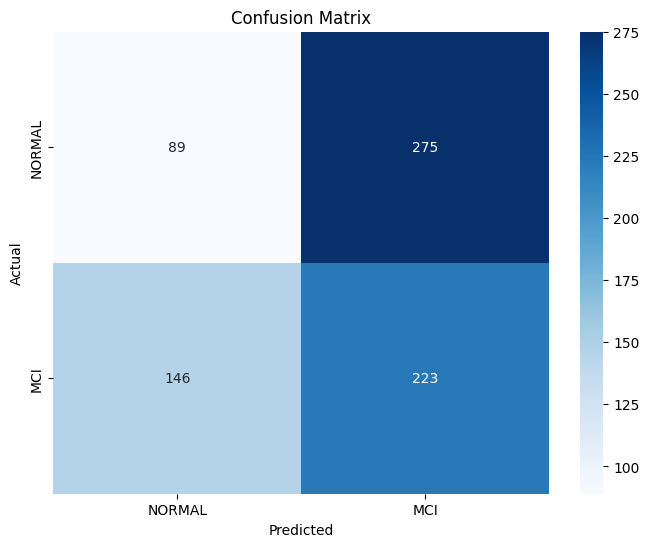

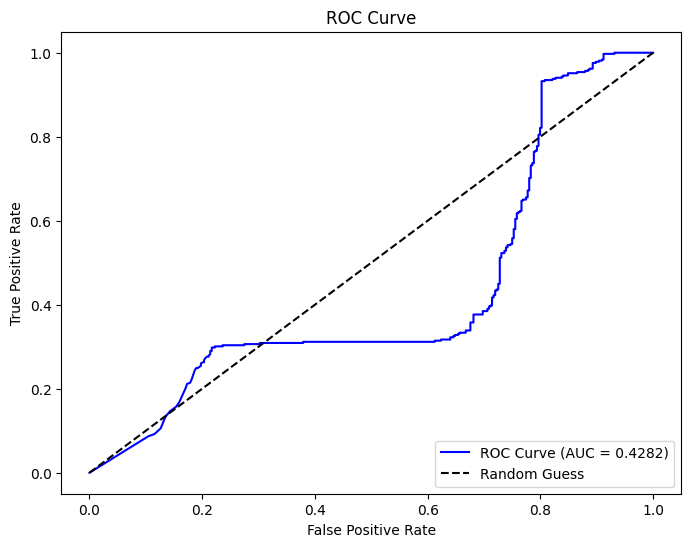

In [6]:
scaler = StandardScaler()
test_features = scaler.fit_transform(test_data_array.reshape(-1, test_data_array.shape[-1])).reshape(test_data_array.shape)
test_features = torch.tensor(test_features, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_label_array, dtype=torch.float32).unsqueeze(1).to(device)
test_dataset = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the best model on test set
model = CNNModel(input_shape=test_features.shape).to(device)
model.load_state_dict(torch.load('/kaggle/working/best_model_fold_3.pth'))
model.eval()

all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = outputs.cpu().numpy()
        predicted = (outputs >= 0.5).float()
        all_preds.extend(predicted.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())
        all_probs.extend(probs.flatten())

# Calculate metrics
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{cm}")
# Plot Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'MCI'], yticklabels=['NORMAL', 'MCI'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()
plt.close()

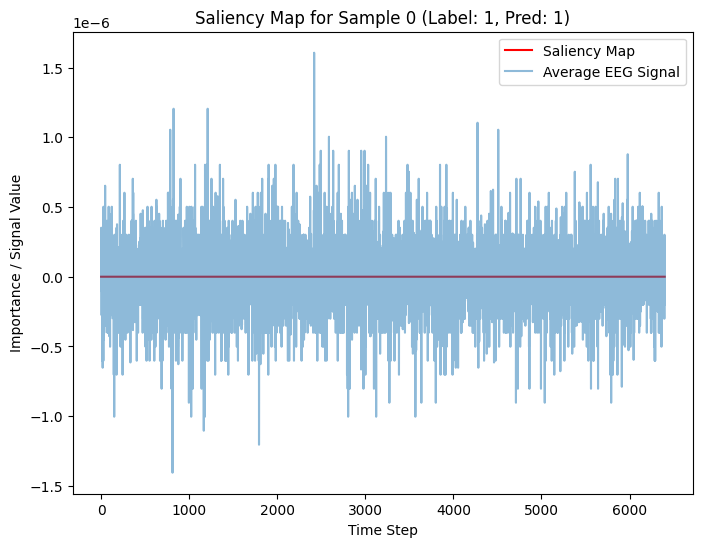

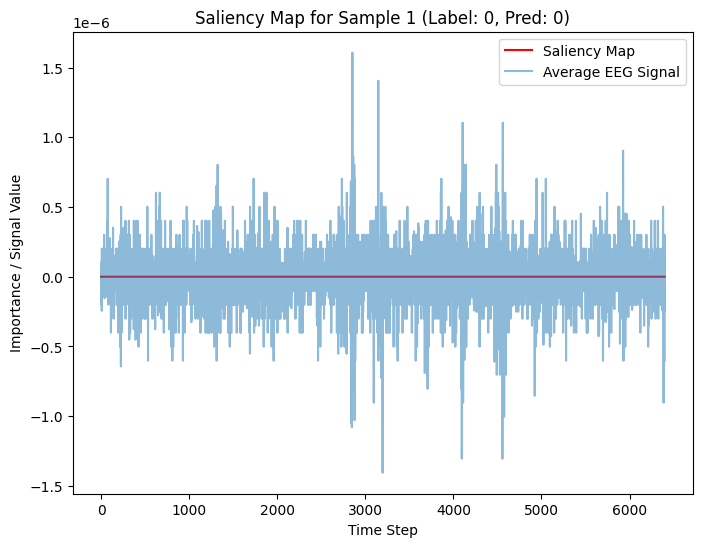

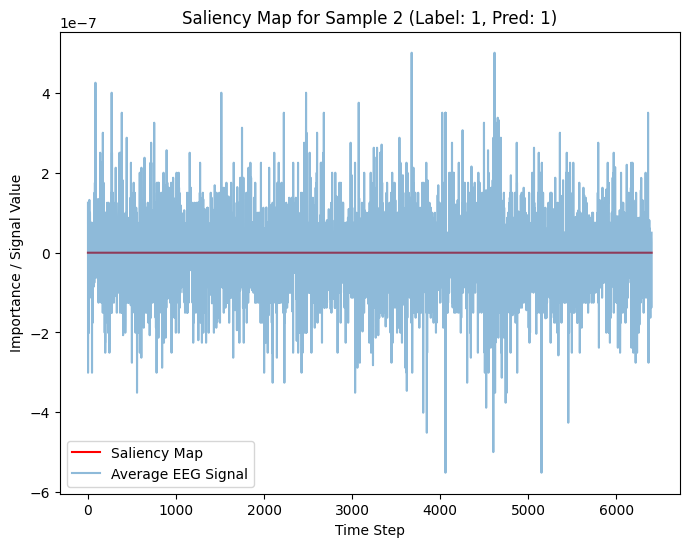

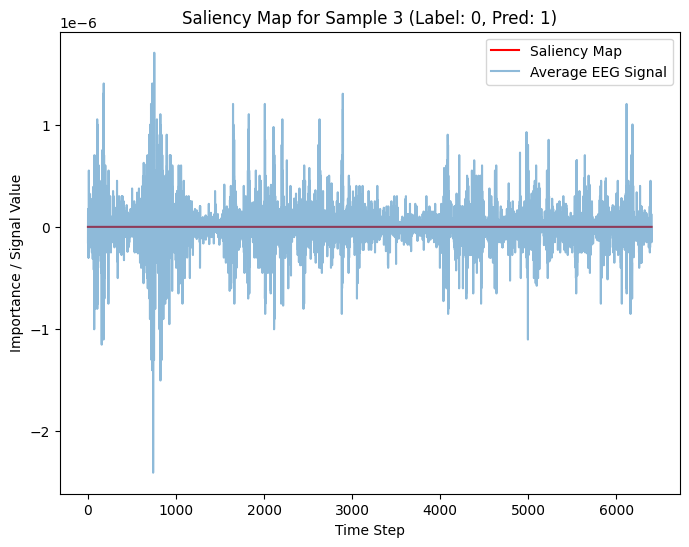

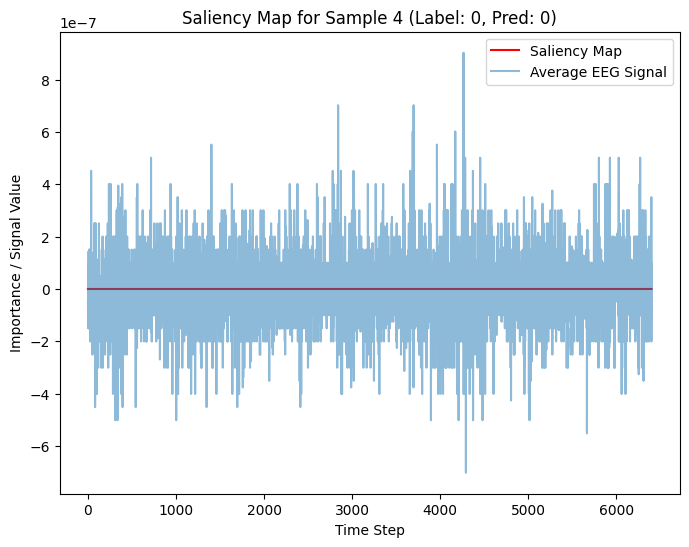

Confusion Matrix:
 [[2 1]
 [0 2]]


In [7]:
# Define function to compute Saliency Maps
import random
def compute_saliency_map(model, input_data, target_class, device):
    model.eval()
    input_data = input_data.unsqueeze(0).to(device).requires_grad_(True)  # Shape: (1, channels, length)

    # Forward pass
    output = model(input_data)
    model.zero_grad()

    # Backward pass to get gradients
    output.backward()  # For binary classification, backpropagate the single output

    # Get the gradients of the input
    saliency = input_data.grad.abs().squeeze(0).cpu().numpy()  # Shape: (channels, sequence_length)
    saliency = np.mean(saliency, axis=0)  # Average over channels to get a 1D saliency map
    return saliency

# Load the pre-trained model (adjust path accordingly)
model_path = "/kaggle/working/best_model_fold_3.pth"  # Thay bằng đường dẫn tới file trọng số đã lưu
model.load_state_dict(torch.load(model_path))
model.eval()

# Prepare test data for Saliency Maps
test_dataset = TensorDataset(torch.tensor(test_data_array, dtype=torch.float32), 
                             torch.tensor(test_label_array, dtype=torch.float32).unsqueeze(1))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

flat_samples = [(x[0], x[1]) for x in list(test_loader)]
random_samples = random.sample(flat_samples, 5)
# Compute and visualize Saliency Maps
saliency_maps = []
all_preds = []
all_labels = []
all_probs = []

for i, (inputs, labels) in enumerate(random_samples):
    inputs, labels = inputs.to(device), labels.to(device)
    output = model(inputs)
    probs = output.detach().cpu().numpy().flatten()
    predicted = (output >= 0.5).float()
    all_preds.extend(predicted.cpu().numpy().flatten())
    all_labels.extend(labels.cpu().numpy().flatten())
    all_probs.extend(probs)

    # Compute Saliency Map
    saliency = compute_saliency_map(model, inputs.squeeze(0), int(labels.item()), device)
    saliency_maps.append((i, saliency))

    # Visualize Saliency Map
    plt.figure()
    plt.plot(saliency, label='Saliency Map', color='red')
    plt.plot(inputs.squeeze(0).cpu().numpy().mean(axis=0), label='Average EEG Signal', alpha=0.5)
    plt.title(f'Saliency Map for Sample {i} (Label: {int(labels.item())}, Pred: {int(predicted.item())})')
    plt.xlabel('Time Step')
    plt.ylabel('Importance / Signal Value')
    plt.legend()
    plt.savefig(f'saliency_map_sample_{i}.png')
    plt.show()

# Calculate metrics
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

In [8]:
import torch
import torch.nn.functional as F
import numpy as np

def compute_gradcam_1d(model, input_tensor, target_class, device, target_layer='conv5'):
    model.eval()
    input_tensor = input_tensor.unsqueeze(0).to(device).requires_grad_(True)

    # Hook để lưu feature map và gradient tại tầng conv5
    activation = {}
    gradients = {}

    def forward_hook(module, input, output):
        activation['value'] = output.detach()

    def backward_hook(module, grad_input, grad_output):
        gradients['value'] = grad_output[0].detach()

    # Đăng ký hook vào tầng conv5
    hook_f = getattr(model, target_layer).register_forward_hook(forward_hook)
    hook_b = getattr(model, target_layer).register_backward_hook(backward_hook)

    # Forward
    output = model(input_tensor)
    model.zero_grad()

    # Backward cho lớp đích
    output[0][0].backward()

    # Lấy feature map và gradient
    fmap = activation['value'][0]  # shape: (C, L)
    grads = gradients['value'][0]  # shape: (C, L)

    # Tính trọng số theo Global Average Pooling
    weights = grads.mean(dim=1)  # shape: (C)

    # Tính Grad-CAM bằng cách nhân trọng số với feature map
    gradcam = torch.sum(weights[:, None] * fmap, dim=0)  # shape: (L,)
    gradcam = F.relu(gradcam)

    # Chuẩn hóa về [0, 1]
    gradcam = gradcam.cpu().numpy()
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-8)

    # Gỡ hook
    hook_f.remove()
    hook_b.remove()

    return gradcam


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


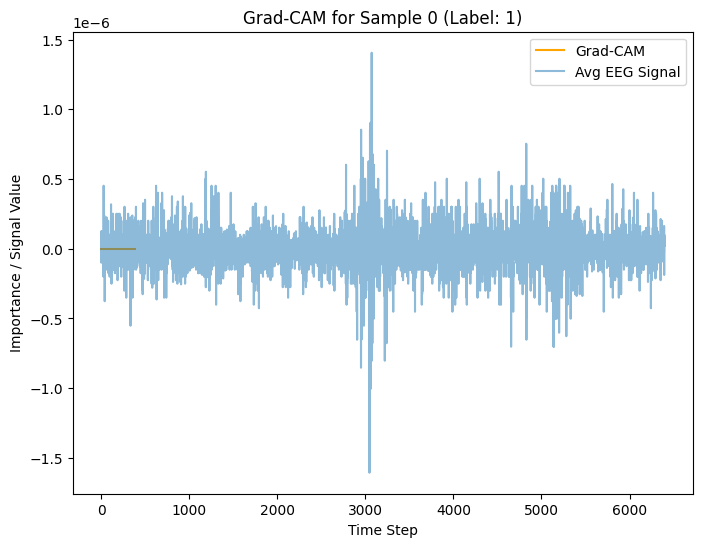

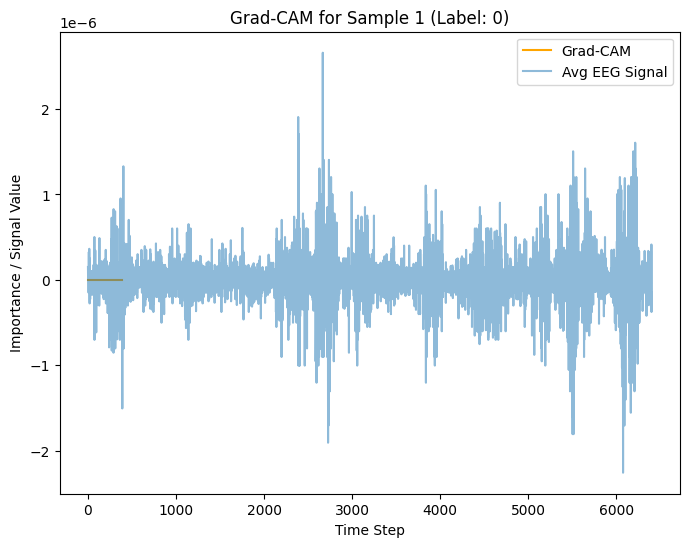

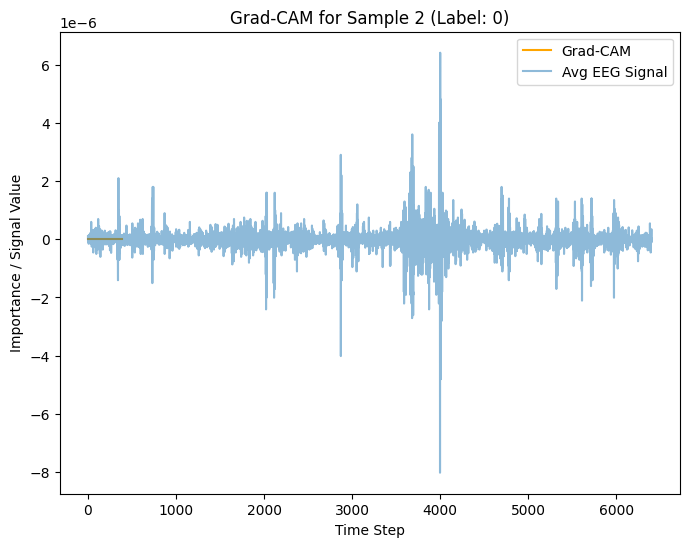

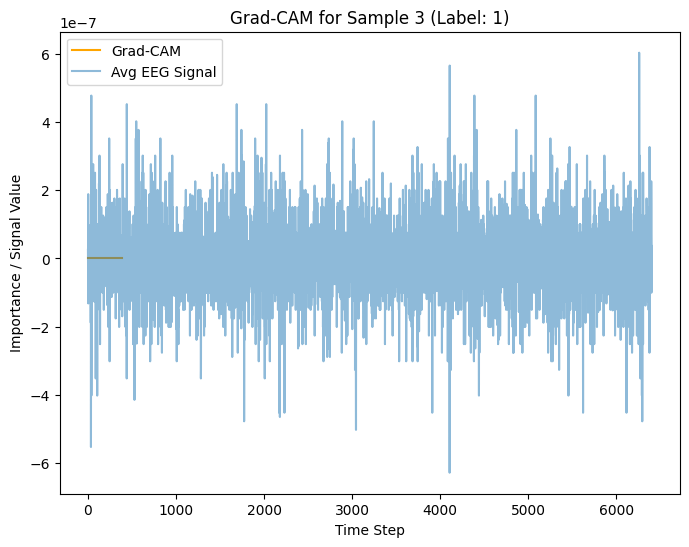

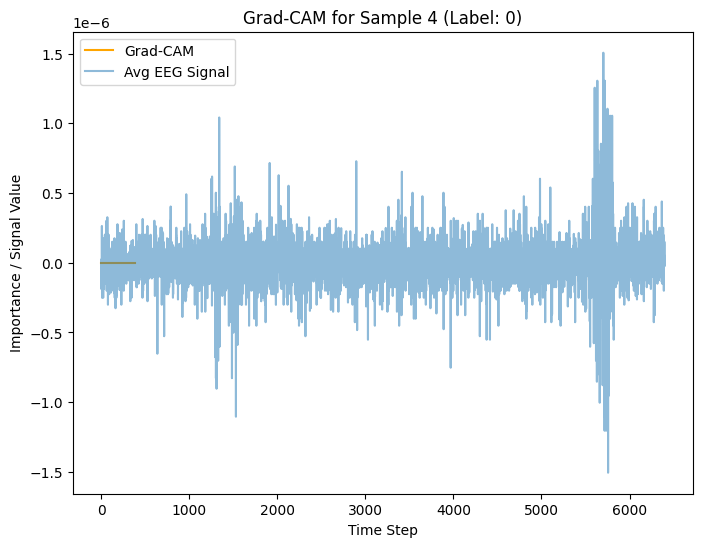

In [9]:
test_dataset = TensorDataset(torch.tensor(test_data_array, dtype=torch.float32), 
                             torch.tensor(test_label_array, dtype=torch.float32).unsqueeze(1))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

flat_samples = [(x[0], x[1]) for x in list(test_loader)]
random_samples = random.sample(flat_samples, 5)
model_path = "/kaggle/working/best_model_fold_3.pth"  # Thay bằng đường dẫn tới file trọng số đã lưu
model.load_state_dict(torch.load(model_path))
for i, (inputs, labels) in enumerate(random_samples):
    inputs, labels = inputs.to(device), labels.to(device)
    gradcam_map = compute_gradcam_1d(model, inputs.squeeze(0), int(labels.item()), device)
    plt.figure()
    plt.plot(gradcam_map, label='Grad-CAM', color='orange')
    plt.plot(inputs.squeeze(0).cpu().numpy().mean(axis=0), label='Avg EEG Signal', alpha=0.5)
    plt.title(f'Grad-CAM for Sample {i} (Label: {int(labels.item())})')
    plt.xlabel('Time Step')
    plt.ylabel('Importance / Signal Value')
    plt.legend()
    plt.savefig(f'gradcam_sample_{i}.png')
    plt.show()
    plt.close()
    if i == 5:
        break
